In [ ]:
#Install & imports
!pip install openpyxl
!pip install tensorflow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


Loading the Excel data


In [ ]:
#Load your spreadsheet
file_path = '/GHI_MW_Complete_final.xlsx'
df = pd.read_excel(file_path, sheet_name='Sheet1')

#parse the timestamp
df['Datetime'] = pd.to_datetime(df['time_ist'])
df = df.sort_values('Datetime').set_index('Datetime')

#pick one station to forecast
station = 'Avaada_Sunrays'

#rename to the generic names our pipeline expects:
df_station = df[[f'{station}_GHI', f'{station}_MW']].dropna()
df_station.columns = ['GHI', 'Solar_MW_Generation']

#inspect
df_station.head()


,GHI,Solar_MW_Generation
Datetime,,
2024-06-01 06:30:00,21.6250,21.760
2024-06-01 06:45:00,57.8235,33.280
2024-06-01 07:00:00,94.0220,48.128
2024-06-01 07:15:00,130.2205,66.304
2024-06-01 07:30:00,166.4190,87.424


Process and Feature Engineering

In [ ]:
#extract time features
df_station['Hour']   = df_station.index.hour
df_station['Minute'] = df_station.index.minute

#lag + rolling
df_station['GHI_Lag1']    = df_station['GHI'].shift(1)
df_station['GHI_Rolling'] = df_station['GHI'].rolling(window=3, min_periods=1).mean()

df_station = df_station.dropna()

#build X, y
features = ['GHI','Hour','Minute','GHI_Lag1','GHI_Rolling']
X = df_station[features].values
y = df_station['Solar_MW_Generation'].values.reshape(-1,1)

#scale
scaler_X = MinMaxScaler(); X_scaled = scaler_X.fit_transform(X)
scaler_y = MinMaxScaler(); y_scaled = scaler_y.fit_transform(y)


Making Sequences for LSTM

In [ ]:
TIME_STEPS = 3

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i+time_steps)])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, TIME_STEPS)

#train/test split
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]


Building and Training LSTM


In [ ]:
n_features = X_train.shape[2]

model = Sequential([
    LSTM(50, activation='relu', input_shape=(TIME_STEPS, n_features)),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1218 - val_loss: 0.0316
Epoch 2/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0274 - val_loss: 0.0269
Epoch 3/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0247 - val_loss: 0.0240
Epoch 4/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0241 - val_loss: 0.0233
Epoch 5/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0221 - val_loss: 0.0214
Epoch 6/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0231 - val_loss: 0.0205
Epoch 7/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0218 - val_loss: 0.0195
Epoch 8/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0213 - val_loss: 0.0248
Epoch 9/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0208 - val_loss: 0.0237
Epoch 10/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0200 - val_loss: 0.0218
Epoch 11/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0197 - val_loss: 0.0214
Epoch 12/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Evalaution of the test set

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Test RMSE: 47.929, MAE: 39.249


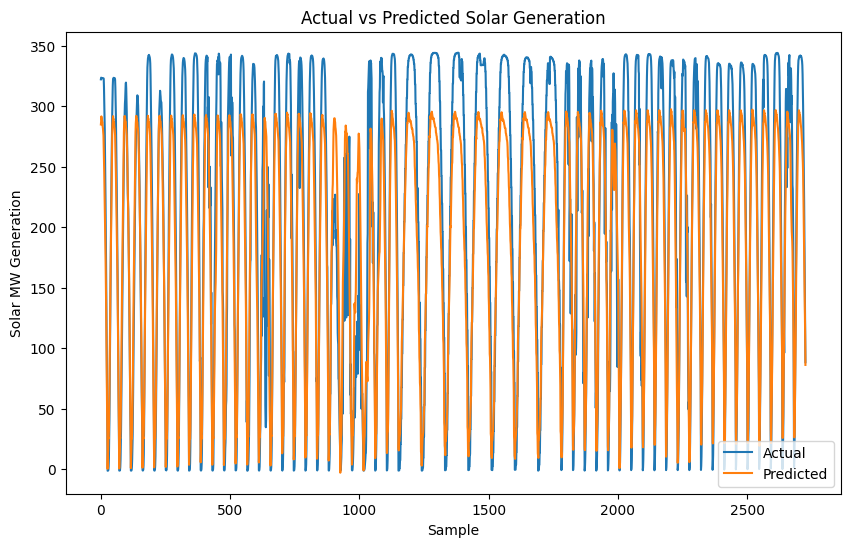

In [ ]:
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
print(f"Test RMSE: {rmse:.3f}, MAE: {mae:.3f}")

plt.figure(figsize=(10,6))
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Solar Generation')
plt.xlabel('Sample')
plt.ylabel('Solar MW Generation')
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import r2_score

#Recompute metrics
mae  = mean_absolute_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

#Grab the test timestamps
# df_station is your DataFrame indexed by datetime
# and TIME_STEPS, split are from your sequence setup
all_dates  = df_station.index[TIME_STEPS:]    # one timestamp per y_seq
test_dates = all_dates[split:]               # only the test‑set portion

#Print out the first 30 pairs
print("\nTime: Actual vs Predicted")
for i in range(min(30, len(test_dates))):
    t = test_dates[i]
    a = y_true[i][0]
    p = y_pred[i][0]
    print(f"{t} → Actual: {a:.3f}, Predicted: {p:.3f}")


Mean Absolute Error (MAE): 39.2487
R² Score: 0.8346

Time: Actual vs Predicted
2025-01-29 11:15:00 → Actual: 322.304, Predicted: 285.002
2025-01-29 11:30:00 → Actual: 323.712, Predicted: 287.565
2025-01-29 11:45:00 → Actual: 323.328, Predicted: 291.676
2025-01-29 12:00:00 → Actual: 323.200, Predicted: 289.108
2025-01-29 12:15:00 → Actual: 323.456, Predicted: 289.469
2025-01-29 12:30:00 → Actual: 323.328, Predicted: 286.662
2025-01-29 12:45:00 → Actual: 323.328, Predicted: 286.869
2025-01-29 13:00:00 → Actual: 323.328, Predicted: 283.072
2025-01-29 13:15:00 → Actual: 323.200, Predicted: 281.817
2025-01-29 13:30:00 → Actual: 323.200, Predicted: 278.149
2025-01-29 13:45:00 → Actual: 323.200, Predicted: 275.898
2025-01-29 14:00:00 → Actual: 322.816, Predicted: 266.261
2025-01-29 14:15:00 → Actual: 315.776, Predicted: 257.215
2025-01-29 14:30:00 → Actual: 304.768, Predicted: 244.869
2025-01-29 14:45:00 → Actual: 293.120, Predicted: 231.692
2025-01-29 15:00:00 → Actual: 280.704, Predicted: 2

Frecasting into the future

In [ ]:
#set this to whichever station you want to forecast
station   = 'Avaada_Sunrays'
ghi_col   = f'{station}_GHI'
mw_col    = f'{station}_MW'

#the Excel you uploaded
file_path = '/GHI_MW_Complete_final.xlsx'

#load exactly the columns we need
future_df = pd.read_excel(file_path, sheet_name='Sheet1',
                          usecols=['time_ist', ghi_col, mw_col])

#rename for our pipeline
future_df = future_df.rename(columns={
    'time_ist': 'time_ist',
    ghi_col:    'GHI',
    mw_col:     'Actual_MW'
})

#datetime → index
future_df['Datetime'] = pd.to_datetime(future_df['time_ist'])
future_df = future_df.set_index('Datetime')

#feature engineering
future_df['Hour']        = future_df.index.hour
future_df['Minute']      = future_df.index.minute
future_df['GHI_Lag1']    = future_df['GHI'].shift(1)
future_df['GHI_Rolling'] = future_df['GHI'].rolling(window=3, min_periods=1).mean()
future_df = future_df.fillna(method='bfill')

#prepare X and build sequences
X_fut        = future_df[features].values
X_fut_scaled = scaler_X.transform(X_fut)
Xf_seq, _    = create_sequences(X_fut_scaled,
                                 np.zeros((len(X_fut_scaled),1)))

#predict & invert your scaler
y_fut_scaled = model.predict(Xf_seq)
y_fut        = scaler_y.inverse_transform(y_fut_scaled)

#assemble your DataFrame
res = pd.DataFrame({
    'Datetime':          future_df.index[TIME_STEPS:],
    'Predicted_Solar_MW': y_fut.flatten(),
    # 'Actual_MW':       future_df['Actual_MW'].iloc[TIME_STEPS:].values  # optional
})

#save as Excel
output_file = f'Future_Solar_Predictions_LSTM_{station}.xlsx'
res.to_excel(output_file, index=False)
print("Saved to", output_file)


 73/426 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

/tmp/ipython-input-12-291085359.py:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_df = future_df.fillna(method='bfill')


426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Saved to Future_Solar_Predictions_LSTM_Avaada_Sunrays.xlsx
